# Cifar-10

The dataset CIFAR-10 contains a collection of photos from 10 different classes. This dataset is frequently used in scientific research to test various machine learning models, particularly for computer vision issues. In order to determine the prediction accuracy that can be achieved, we will attempt to construct a neural network model using Pytorch and test it on the CIFAR-10 dataset.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime 
import gc
import numpy as np

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# Here we set up some parameters which will be used later in the code
# parameters
RANDOM_SEED = 12
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [4]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# declaring the training and test datasets
train_data = datasets.CIFAR10('data', train=True,download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:

# specify the image classes
labels = 'airplane automobile bird cat deer dog frog horse ship truck'.split()

#### Visualizing the Dataset for Feature Extraction
1. After converting the image data to normalised Tensor data I view the images. 
2. Matplotlib is then used to display the images.  
3. Showing the 20 pictures alongside their associated labels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

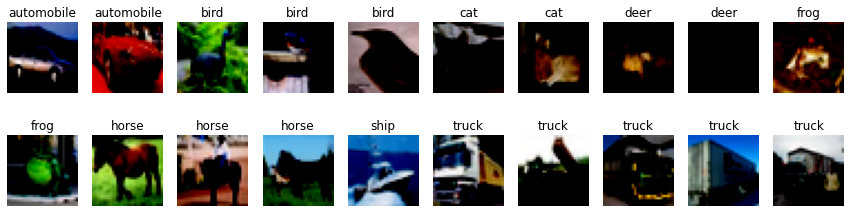

In [7]:
first_20_samples = sorted([train_data[i] for i in range(20)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,21):
    img = first_20_samples[i-1][0].permute(1,2,0)
    label = labels[first_20_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)

The logic behind implementing CIFAR10 dataset is the same as MNIST Dataset, except here in the LeNet model we give 3 input channels since the images in Cifar10 dataset are RGB images. The rest of the procedure is same as the MNIST model implemented before.

In [9]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


In [10]:
model = LeNet5(10).to(device)
print(model)

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


Using the current weights, I get the predictions for each batch of data in the train function. This is known as the Forward Pass. I then figure out the loss function's value. I follow this with a backward pass, where the weights are changed in accordance with the loss. This is known as the "Learning Phase". The model is in training mode (model.train()) for the training phase, and I have also zeroed out the gradients for each batch. Additionally, I find out the running loss throughout the training phase. I then return the model which I'll be implementing, in this case it is LeNet5 model, along with the optimizer used i.e. SGD in my case and the loss obtained after each epoch.

In [11]:
def train(train_loader, model, criterion, optimizer, device):

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    Loss = running_loss / len(train_loader.dataset)
    return model, optimizer, Loss

The main distinction between the testing and training functions is the absence of the actual learning step (the backward pass). Here I am only utilizing the model for evaluation using the model.eval keyword (). Gradients are not a concern because, as in the following method, I have disabled them during the testing phase. In the training loop, I will finally integrate them all.

In [12]:
def test(test_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in test_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    Loss = running_loss / len(test_loader.dataset)
        
    return model, Loss

This funtion is used to plot the training and testing losses. First I have converted the losses obtained into array to be later used in plotting. I have set a figure size and then I have plot the training and testing loss in blue and red respectively. Here my X-axis is the number of epochs and the Y-axis is the loss that I calculate.

In [13]:
def plot_loss(train_losses, valid_losses):

    # change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Testing loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In this function I find the accuracy of the predictions of the entire data loader. Here we basically find the predicted target values and the torch.max function returns me the value which is closest to 1 from each tensor input. I then take the sum of all those predicted values which are equal to the actual target value from the training or testing dataset. Then I return the average of the total number of correctly predicted value using which we calculate the training or testing accuracy later.

In [14]:
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
#             print("Probabilities",y_prob)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In the function below I first pass as paramenters the model to implement, the optimizer to use, the train dataset, test dataset, number of epochs, the device on which the computation is done. Inside the function I create two lists where I store the loss values obtained from the train and test datasets. Here I do not update the weights for test dataset, hence, I use torch.no_grad() function while appending the test loss obtained from the test function. Then for each epoch I calculate the train loss, test loss along with the accuracy and print it. I also plot the graph for the training and testing losses obtained. I also use TensorBoard to view the accuracy and loss graphs.

In [15]:
def evaluation(model, criterion, optimizer, train_loader, test_loader, epochs, device, print_every=1):
    
    # set objects for storing metrics
    train_losses = []
    test_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        writer.add_scalar("Loss train", train_loss, epoch+1)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, test_loss = test(test_loader, model, criterion, device)
            writer.add_scalar("Loss test", test_loss, epoch+1)
            test_losses.append(test_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            writer.add_scalar("Train Accuracy", train_acc, epoch+1)
            test_acc = get_accuracy(model, test_loader, device=device)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)    
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Test loss: {test_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Test accuracy: {100 * test_acc:.2f}')

            
    plot_loss(train_losses, test_losses)
#     train_arr = np.array(train_losses)
#     train_tensor = torch.as_tensor(train_arr)
#     test_arr = np.array(test_losses)
#     test_tensor = torch.as_tensor(test_arr)
#     writer.add_scalar("Loss train", train_losses, epochs)
#     writer.add_scalar("Loss test", test_losses, epochs)
    
    return model, optimizer, (train_losses,test_losses)

In [16]:

model = LeNet5(10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

13:05:56 --- Epoch: 0	Train loss: 2.3004	Test loss: 2.2923	Train accuracy: 14.28	Test accuracy: 14.32
13:06:58 --- Epoch: 1	Train loss: 2.2145	Test loss: 2.1139	Train accuracy: 22.95	Test accuracy: 23.34
13:07:59 --- Epoch: 2	Train loss: 2.0428	Test loss: 1.9702	Train accuracy: 29.20	Test accuracy: 29.41
13:09:02 --- Epoch: 3	Train loss: 1.9027	Test loss: 1.8406	Train accuracy: 32.52	Test accuracy: 32.95
13:10:04 --- Epoch: 4	Train loss: 1.7820	Test loss: 1.9591	Train accuracy: 30.22	Test accuracy: 30.37
13:11:06 --- Epoch: 5	Train loss: 1.6823	Test loss: 1.6500	Train accuracy: 39.37	Test accuracy: 39.91
13:12:07 --- Epoch: 6	Train loss: 1.6100	Test loss: 1.6750	Train accuracy: 40.05	Test accuracy: 39.45
13:13:09 --- Epoch: 7	Train loss: 1.5534	Test loss: 1.5425	Train accuracy: 43.92	Test accuracy: 43.99
13:14:11 --- Epoch: 8	Train loss: 1.4967	Test loss: 1.5349	Train accuracy: 43.63	Test accuracy: 44.04
13:15:13 --- Epoch: 9	Train loss: 1.4545	Test loss: 1.5076	Train accuracy: 46.47	T

/var/folders/mv/39f6vvvn1kb8pjc2zbvyxr5w0000gn/T/ipykernel_11470/308483355.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


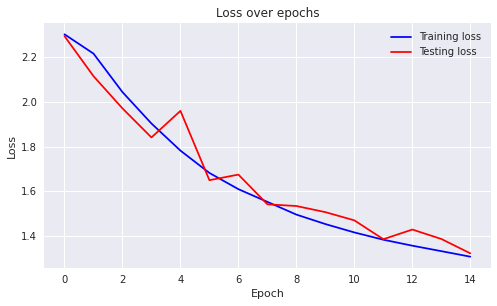

In [17]:
model, optimizer, _ = evaluation(model, criterion, optimizer, train_dataloader, test_dataloader, 15, device)

Here I have set my learning rate to be 0.01 and keeping my optimizer as SGD I observe that there are a lot of bumps in the loss obtained from the test data, unlike the train dataset. There's a lot of fluctuations in teh accuracy from both the datasets which is later viewed in TensorBoard.

11:07:52 --- Epoch: 0	Train loss: 2.3039	Test loss: 2.3036	Train accuracy: 10.00	Test accuracy: 10.00
11:08:53 --- Epoch: 1	Train loss: 2.3034	Test loss: 2.3031	Train accuracy: 10.01	Test accuracy: 9.99
11:09:54 --- Epoch: 2	Train loss: 2.3030	Test loss: 2.3027	Train accuracy: 10.01	Test accuracy: 9.96
11:10:55 --- Epoch: 3	Train loss: 2.3026	Test loss: 2.3022	Train accuracy: 10.02	Test accuracy: 9.95
11:11:56 --- Epoch: 4	Train loss: 2.3021	Test loss: 2.3018	Train accuracy: 10.04	Test accuracy: 9.91
11:12:57 --- Epoch: 5	Train loss: 2.3016	Test loss: 2.3013	Train accuracy: 10.11	Test accuracy: 9.95
11:13:58 --- Epoch: 6	Train loss: 2.3011	Test loss: 2.3006	Train accuracy: 10.19	Test accuracy: 10.00
11:14:59 --- Epoch: 7	Train loss: 2.3004	Test loss: 2.2999	Train accuracy: 10.17	Test accuracy: 10.19
11:16:00 --- Epoch: 8	Train loss: 2.2995	Test loss: 2.2988	Train accuracy: 10.16	Test accuracy: 10.21
11:17:01 --- Epoch: 9	Train loss: 2.2983	Test loss: 2.2974	Train accuracy: 10.23	Test a

/var/folders/mv/39f6vvvn1kb8pjc2zbvyxr5w0000gn/T/ipykernel_10254/308483355.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


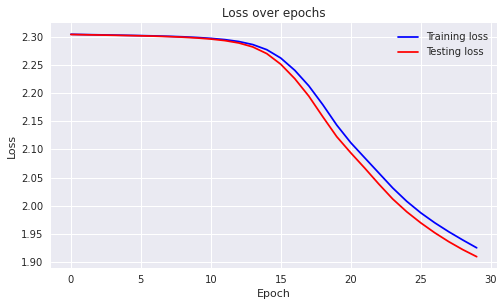

In [16]:
model = LeNet5(10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model, optimizer, _ = evaluation(model, criterion, optimizer, train_dataloader, test_dataloader, 30, device)

In the above case I have set my learning rate to be 0.001 and number of epochs as 30 and still we don't get a very good output as the results reach only 32% accuracy. Hence we can conclude that with such a small learning rate we need to increase the number of epochs so as to get a reasonable test accuracy. We can also see from the graph above that after the 13th epoch or so there is a gradual decrease in the train and test loss.

11:52:51 --- Epoch: 0	Train loss: 1.9291	Test loss: 2.1421	Train accuracy: 27.11	Test accuracy: 27.21
11:53:52 --- Epoch: 1	Train loss: 1.5430	Test loss: 1.8410	Train accuracy: 35.79	Test accuracy: 36.02
11:54:53 --- Epoch: 2	Train loss: 1.3990	Test loss: 1.4100	Train accuracy: 50.50	Test accuracy: 49.50
11:55:54 --- Epoch: 3	Train loss: 1.3012	Test loss: 1.3704	Train accuracy: 53.18	Test accuracy: 51.05
11:56:55 --- Epoch: 4	Train loss: 1.2262	Test loss: 1.5384	Train accuracy: 49.21	Test accuracy: 47.12
11:57:56 --- Epoch: 5	Train loss: 1.1590	Test loss: 1.2440	Train accuracy: 59.81	Test accuracy: 55.94
11:58:57 --- Epoch: 6	Train loss: 1.1011	Test loss: 1.2633	Train accuracy: 59.68	Test accuracy: 55.69
11:59:58 --- Epoch: 7	Train loss: 1.0464	Test loss: 1.2607	Train accuracy: 61.38	Test accuracy: 55.99
12:00:59 --- Epoch: 8	Train loss: 1.0033	Test loss: 1.4021	Train accuracy: 56.03	Test accuracy: 51.66
12:02:00 --- Epoch: 9	Train loss: 0.9650	Test loss: 1.1798	Train accuracy: 65.68	T

/var/folders/mv/39f6vvvn1kb8pjc2zbvyxr5w0000gn/T/ipykernel_10865/308483355.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


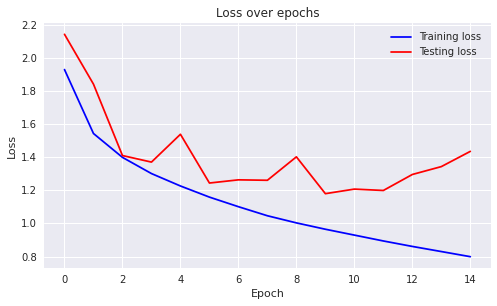

In [16]:
model = LeNet5(10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
model, optimizer, _ = evaluation(model, criterion, optimizer, train_dataloader, test_dataloader, 15, device)

In the above case I have set my learning rate to be 0.1 and number of epochs as 15 and still we don't get a very good output as the results reach only 56% accuracy. Hence we can conclude that Lenet architechture is not modelled for CIFAR10 dataset. We can also see from the graph above that there is a lot of fluctuations in the loss obtained from the test data. We also see quite an amount of fluctuations in the accuracy of both the train and test datasets.